In [1]:
from log_parser_lib import *
import os
import pickle as pkl
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from numpy import log as ln
from math import log

In [2]:
log_path = '/home/dpnm/tmp/OpensourceLog/Linux.log'
log_data=read_file(log_path)
print(f'##Read total {len(log_data)} num of logs##')

##Read total 25567 num of logs##


In [3]:
log_dict, synant_dict=make_dict(log_data)
log_patterns=make_log_pattern_dict(log_data, log_dict)
event_list=classify_pattern_to_events(log_patterns,synant_dict)


########################################
Here are most frequent vocabularies.
[('out', 10501), ('process', 10491), ('memory', 10452), ('of', 10428), ('killed', 10404), ('httpd', 9018), ('user', 5180), ('uid', 4614), ('euid', 4053), ('failure', 4032)]

########################################
Here are most frequent log patterns
out of memory killed process httpd : 8903
authentication failure logname uid euid tty nodevssh ruser rhost user root : 1597
connection from at [date] [date] : 1580
out of memory killed process python : 1153
check pass user unknown : 1043
authentication failure logname uid euid tty nodevssh ruser rhost : 452
creating device node [path] : 268
authentication failure logname uid euid tty nodevssh ruser rhost user test : 242
session opened for user cyrus by uid : 231
session closed for user cyrus : 231
Find 970 number of log patterns

########################################
Total num of event is 332
Total num of log pattern is 970


In [7]:
num_all_log=len(log_data)
num_all_doc=3

# let's calcurate tf-idf of all patterns
tf_idf=[0 for _ in range(len(log_patterns))]
tmp_df=[False for _ in range(len(log_patterns))]
date_now=log_data[0]['date'].date()
#print(date_now)
for single_log in log_data:
    if date_now < single_log['date'].date() or date_now.month==12 and single_log['date'].month==1:
        num_all_doc+=1
        for i in range(len(tmp_df)):
            if tmp_df[i]:
                tf_idf[i]+=1
        tmp_df=[False for _ in range(len(log_patterns))]
        date_now=single_log['date'].date()
        #print(date_now)
    single_pattern=log_parser(single_log, log_dict)
    if single_pattern==[]:continue
    tmp_df[find_pattern_num(single_pattern,log_patterns)-1]=True
for i in range(len(tmp_df)):
    if tmp_df[i]:
        tf_idf[i]+=1
print(f'there is {num_all_doc-2} days in log data')
df=tf_idf[:]
tf=[]
idf=[]
for i in range(len(tf_idf)):
    tf.append(ln(num_all_log/(1+log_patterns[i][1])))
    idf.append(num_all_doc+2/(1+tf_idf[i]))
    tf_idf[i]=ln(tf[i]*idf[i])
print(f'tf-idf of all patterns are calculated')
print(f'averagae of tf-idf is {sum(tf_idf)/len(tf_idf)} and std is {sum((tf_idf[i]-sum(tf_idf)/len(tf_idf))**2 for i in range(len(tf_idf)))/len(tf_idf)}, max is {max(tf_idf)}, min is {min(tf_idf)}')
print(f'average of tf is {sum(tf)/len(tf)} and std is {sum((tf[i]-sum(tf)/len(tf))**2 for i in range(len(tf)))/len(tf)} and max is {max(tf)} and min is {min(tf)}')
print(f'average of idf is {sum(idf)/len(idf)} and std is {sum((idf[i]-sum(idf)/len(idf))**2 for i in range(len(idf)))/len(idf)} and max is {max(idf)} and min is {min(idf)}')

there is 263 days in log data
tf-idf of all patterns are calculated
averagae of tf-idf is 7.683399494421818 and std is 0.025873212235381415, max is 7.830136310417197, min is 5.633397165140071
average of tf is 8.26457996536065 and std is 1.1818235527956908 and max is 9.455910555851949 and min is 1.0548018434565136
average of idf is 265.6842962302227 and std is 0.12899648659793167 and max is 266.0 and min is 265.0086206896552


In [8]:
date_now.month

2

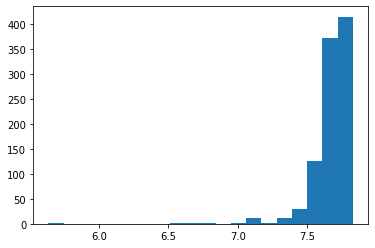

In [9]:
import matplotlib.pyplot as plt
plt.hist(tf_idf, bins=20)
plt.show()

In [36]:
num_=0
for i, log_pattern in enumerate(log_patterns):
    if tf_idf[i]>6.5:
        print(' '.join(log_pattern[0])+': '+str(tf[i]))
        num_+=1
print(num_)

ext fs hda [UNK] on readonly fs: 9.455910555851949
ext fs hda [UNK]: 9.455910555851949
authentication failure logname uid euid tty nodevssh ruser rhost [UNK] ro: 9.455910555851949
authentication failure logname uid euid tty nodevssh ruser rhost unknown sagonet net user root: 6.971003906063949
connection from mail net star com tw at [date] [date]: 6.971003906063949
connection from host stsk macomnet net at [date] [date]: 6.971003906063949
connection from tampabay res rr com at [date] [date]: 6.971003906063949
authentication failure logname uid euid tty nodevssh ruser rhost under eepc kaist ac kr user root: 7.7511624636135235
authentication failure logname uid euid tty nodevssh ruser rhost under eepc kaist ac kr: 7.7511624636135235
authentication failure logname uid euid tty nodevssh ruser rhost ctinets com: 7.7511624636135235
authentication failure logname uid euid tty nodevssh ruser rhost d rev krline net: 8.35729826718384
connection from bflony adelphia net at [date] [date]: 7.9518331

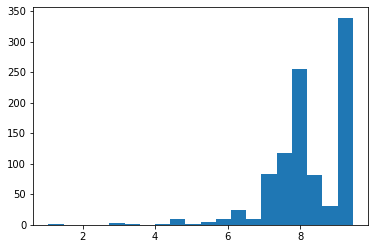

In [25]:
plt.hist(tf, bins=20)
plt.show()

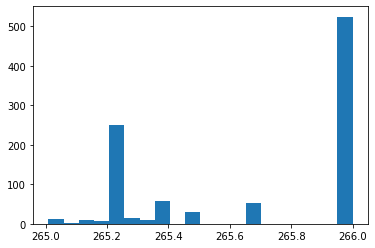

In [15]:
plt.hist(idf, bins=20)
plt.show()

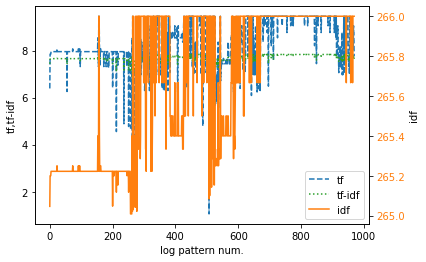

In [14]:
x=range(len(tf_idf))
fig, ax1 = plt.subplots()
plt.xlabel('log pattern num.')
ax2=ax1.twinx()
ln3=ax2.plot(x, idf, label='idf', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ln1=ax1.plot(x, tf, '--', label='tf')
ln2=ax1.plot(x, tf_idf, ':', label='tf-idf', color='tab:green')
ax1.set_ylabel('tf,tf-idf')

ax2.set_ylabel('idf')
lns=ln1+ln2+ln3
labs=[l.get_label() for l in lns]
ax1.legend(lns,labs,loc='lower right')
#fig.tight_layout()
#fig.legend(loc='upper right')
plt.show()

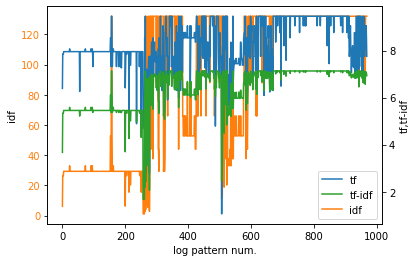

In [54]:
x=range(len(tf_idf))
fig, ax1 = plt.subplots()
plt.xlabel('log pattern num.')
ax2=ax1.twinx()
ln3=ax1.plot(x, idf, label='idf', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')
ln1=ax2.plot(x, tf, label='tf')
ln2=ax2.plot(x, tf_idf, label='tf-idf', color='tab:green')
ax2.set_ylabel('tf,tf-idf')

ax1.set_ylabel('idf')
lns=ln1+ln2+ln3
labs=[l.get_label() for l in lns]
ax1.legend(lns,labs,loc='lower right')
#fig.tight_layout()
#fig.legend(loc='upper right')
plt.show()

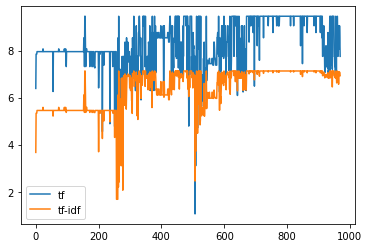

In [39]:
x=range(len(tf_idf))
plt.plot(x, tf, label='tf')
plt.plot(x, tf_idf, label='tf-idf')
plt.legend()
plt.show()

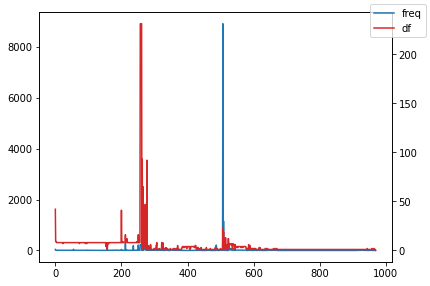

In [22]:
y=[]
for i in range(len(tf_idf)):
    y.append(log_patterns[i][1])
    
fig, ax1 = plt.subplots()
ax1.plot(x,y,label='freq')

ax2=ax1.twinx()
ax2.plot(x, df, color='tab:red',label='df')
fig.tight_layout()
fig.legend(loc='upper right')
plt.show()

In [38]:
print(len(event_list))
event_list

332


[[('restart',)],
 [('syslogd', 'startup', 'succeeded'),
  ('klogd', 'startup', 'succeeded'),
  ('irqbalance', 'startup', 'succeeded'),
  ('portmap', 'startup', 'succeeded'),
  ('rpc', 'statd', 'startup', 'succeeded'),
  ('rpc', 'idmapd', 'startup', 'succeeded'),
  ('hcid', 'startup', 'succeeded'),
  ('sdpd', 'startup', 'succeeded'),
  ('apmd', 'startup', 'succeeded'),
  ('automount', 'startup', 'succeeded'),
  ('smartd', 'startup', 'succeeded'),
  ('cupsd', 'startup', 'succeeded'),
  ('xinetd', 'startup', 'succeeded'),
  ('sendmail', 'startup', 'succeeded'),
  ('sm', 'client', 'startup', 'succeeded'),
  ('spamd', 'startup', 'succeeded'),
  ('privoxy', 'startup', 'succeeded'),
  ('gpm', 'startup', 'succeeded'),
  ('htt', 'startup', 'succeeded'),
  ('crond', 'startup', 'succeeded'),
  ('xfs', 'startup', 'succeeded'),
  ('anacron', 'startup', 'succeeded'),
  ('atd', 'startup', 'succeeded'),
  ('messagebus', 'startup', 'succeeded'),
  ('httpd', 'startup', 'succeeded'),
  ('named', 'startup